In [ ]:
import tensorflow as tf

use_tpu = True

if use_tpu == True:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)



In [ ]:
import os
from google.colab import drive 

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/MyDrive/7001p_ass_2/")
# os.chdir("/content/drive/MyDrive/Colab_uni/7001p_ass_2/")

Mounted at /content/drive


# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [ ]:
import pandas as pd
import glob
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [ ]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [ ]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [ ]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [ ]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [ ]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

<ipython-input-9-3a505b615f58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

To get unique tags:

In [ ]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [ ]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [ ]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [ ]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [ ]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [ ]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [ ]:
MAX_LENGTH = 150

In [ ]:
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [ ]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [ ]:
print(len(train_input[11050]))
train_input[11050]


150


array([  71,   68,  194,   13,   18,   91,   64, 3173,  281, 2226,   52,
       2702,  130,   52,  858,   38,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [ ]:
sentence_embeddings[11050]

[71, 68, 194, 13, 18, 91, 64, 3173, 281, 2226, 52, 2702, 130, 52, 858, 38, 3]

# Model 1 - 

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word 
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [ ]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding
from tensorflow.keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

def create_model():
  return Sequential([
      InputLayer((MAX_LENGTH)),
      Embedding(VOCAB_SIZE, EMBED_SIZE),
      Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)),
      Bidirectional(LSTM(HIDDEN_SIZE)),
      Dense(43),
      Activation("softmax")
    ])


# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation


with strategy.scope():
  model = create_model()
  model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          4373200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 43)                3741      
                                                                 
 activation_1 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
No

In [ ]:
# Train the model - use validation
with strategy.scope():
  model.fit(train_input, train_labels, validation_data=(val_input, val_labels),epochs=5)

Epoch 1/5
4375/4375 [==============================] - 171s 34ms/step - loss: 1.1987 - accuracy: 0.6474 - val_loss: 1.0114 - val_accuracy: 0.6964
Epoch 2/5
4375/4375 [==============================] - 153s 35ms/step - loss: 0.8638 - accuracy: 0.7350 - val_loss: 0.9547 - val_accuracy: 0.7104
Epoch 3/5
4375/4375 [==============================] - 141s 32ms/step - loss: 0.7476 - accuracy: 0.7666 - val_loss: 0.9494 - val_accuracy: 0.7074
Epoch 4/5
4375/4375 [==============================] - 141s 32ms/step - loss: 0.6662 - accuracy: 0.7899 - val_loss: 0.9818 - val_accuracy: 0.7066
Epoch 5/5
4375/4375 [==============================] - 142s 33ms/step - loss: 0.6030 - accuracy: 0.8079 - val_loss: 1.0333 - val_accuracy: 0.6991


In [ ]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 16s 26ms/step - loss: 1.0378 - accuracy: 0.6989


In [ ]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 69.89374160766602


## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice. 

## Minority Classes

In [ ]:
l = len(one_hot_encoding_dic.columns)
conversion_list = [-1]*l

for col in one_hot_encoding_dic:
  index = one_hot_encoding_dic.index[one_hot_encoding_dic[col] == 1][0]
  conversion_list[index] = col
  
print(conversion_list)

['t3', 'b', '^g', '^2', 'ar', 'fc', 'qrr', 'nn', 't1', 'br', '^q', 'fa', 'fp', 'ft', 'aa', 'na', 'sv', 'x', 'qy', 'h', 'ad', 'qw^d', 'bk', 'ng', 'no', 'fo_o_fw_"_by_bc', 'ba', 'sd', 'qw', 'b^m', 'bh', 'arp_nd', 'aap_am', 'ny', '^h', '+', 'bf', '%', 'qy^d', 'bd', 'oo_co_cc', 'qh', 'qo']


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
test_predicted_classes = np.argmax(model.predict(test_sentences_X), axis=1)

1747/1747 [==============================] - 35s 19ms/step


In [ ]:
def confusion_matrix_calculator(class_name, predicted_classes):
  class_index = np.argwhere(one_hot_encoding_dic[class_name].to_numpy() == 1)[0,0]
  index_test_pre = np.array([1 if idx[class_index] == 1 else 0 for idx in y_test])
  index_test = np.argwhere(index_test_pre == 1).flatten()

  # preds_pre = np.argmax(model.predict(test_sentences_X), axis=1) == class_index
  preds_pre = predicted_classes == class_index
  preds = np.array([1 if idx == True else 0 for idx in preds_pre])
  conf = confusion_matrix(index_test_pre, preds)
  sns.heatmap(conf, annot=True)

  ### True Negative   False Positive
  ### False Negative  True Positive
  return conf

In [ ]:
def full_confusion_matrix_plot(predicted_classes):
  conf = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

  fig, axs = plt.subplots(figsize=(10,7))
  sns.heatmap(conf, xticklabels=conversion_list, yticklabels=conversion_list)

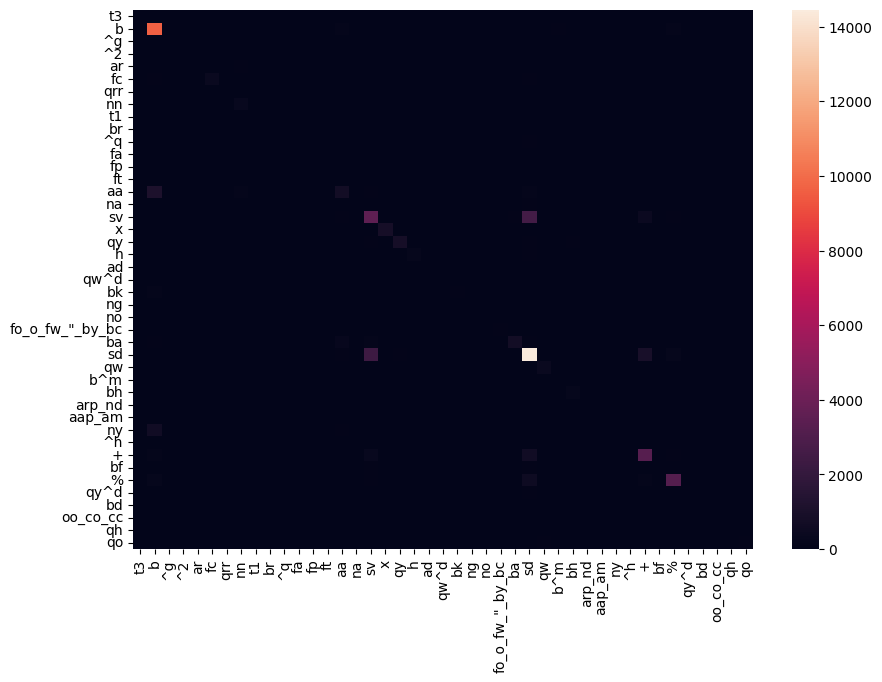

In [ ]:
full_confusion_matrix_plot(test_predicted_classes)

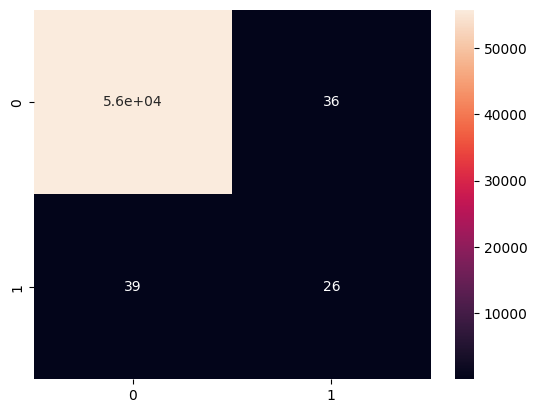

In [ ]:
br_conf = confusion_matrix_calculator("br", test_predicted_classes)

In [ ]:
br_conf

array([[55801,    36],
       [   39,    26]])

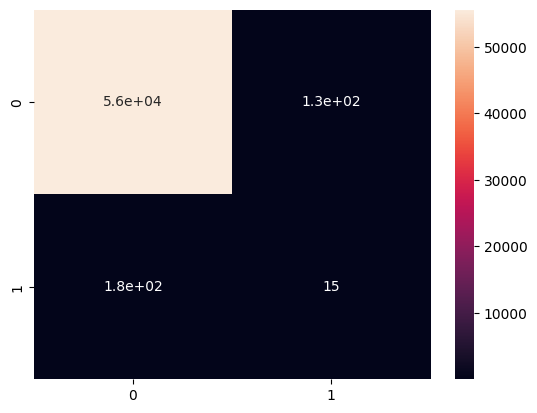

In [ ]:
bf_conf = confusion_matrix_calculator("bf", test_predicted_classes)

In [ ]:
def metrics_from_conf(conf, v = 1):
  tn, fp, fn, tp = conf.ravel()
  acc = (tp+tn) / (tn+fp+fn+tp)
  pre = (tp) / (tp+fp)
  rec = (tp) / (tp+fn)
  return acc, pre, rec

In [ ]:
# Calculate Accuracies for "br" and "bf"
br_acc, br_pre, br_rec = metrics_from_conf(br_conf)
bf_acc, bf_pre, bf_rec = metrics_from_conf(bf_conf)

print(f"br accuracy: {br_acc*100:.2f}%")
print(f"br precision: {br_pre*100:.2f}%")
print(f"br recall: {br_rec*100:.2f}%")
print()
print(f"bf accuracy: {bf_acc*100:.2f}%")
print(f"bf precision: {bf_pre*100:.2f}%")
print(f"bf recall: {bf_rec*100:.2f}%")

br accuracy: 99.87%
br precision: 41.94%
br recall: 40.00%

bf accuracy: 99.44%
bf precision: 10.20%
bf recall: 7.65%


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here. 




sd accuracy: 84.02%
sd precision: 74.68%
sd recall: 78.16%


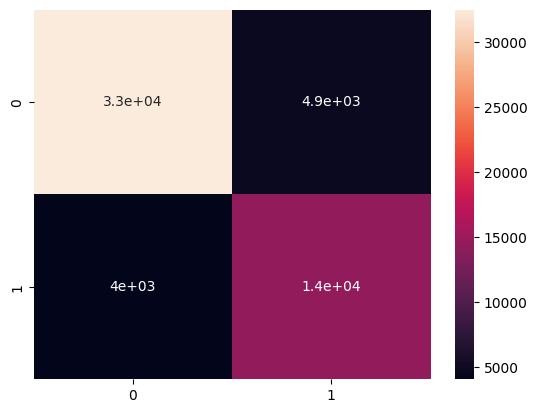

In [ ]:
sd_conf = confusion_matrix_calculator("sd",test_predicted_classes)
sd_acc, sd_pre, sd_rec = metrics_from_conf(sd_conf)

print(f"sd accuracy: {sd_acc*100:.2f}%")
print(f"sd precision: {sd_pre*100:.2f}%")
print(f"sd recall: {sd_rec*100:.2f}%")

b accuracy: 94.42%
b precision: 78.98%
b recall: 94.59%


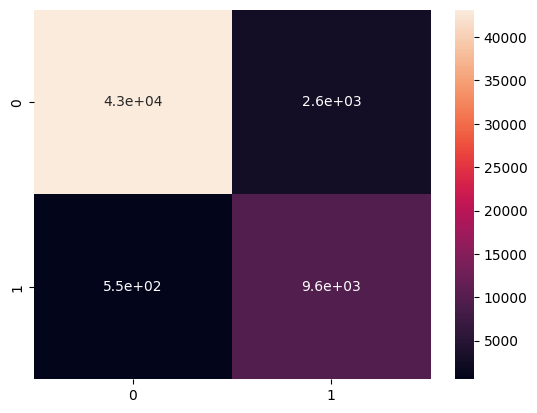

In [ ]:
b_conf = confusion_matrix_calculator("b", test_predicted_classes)
b_acc, b_pre, b_rec = metrics_from_conf(b_conf)

print(f"b accuracy: {b_acc*100:.2f}%")
print(f"b precision: {b_pre*100:.2f}%")
print(f"b recall: {b_rec*100:.2f}%")

## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare. 

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class. 

In [ ]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


In [ ]:
sd_frequency = value_counts["sd"]/sum(value_counts)
print("sd frequency: " + str(sd_frequency*100) + "%")

sd frequency: 33.721367047395866%


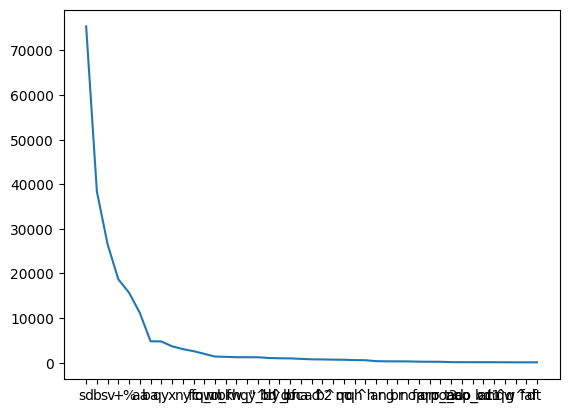

In [ ]:
# Plot the frequencies of the classes

plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [ ]:
# Re-built the model for the balanced training

with strategy.scope():
  model_balanced = create_model()
  model_balanced.compile(loss="categorical_crossentropy",
                         optimizer=Adam(),metrics=['accuracy'])

model_balanced.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          4373200   
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 43)                3741      
                                                                 
 activation_2 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
No

In [ ]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
with strategy.scope():
  model_balanced.fit(train_input, train_labels, validation_data=(val_input, val_labels),epochs=5,
            class_weight=d_class_weights)

Epoch 1/5
4375/4375 [==============================] - 175s 37ms/step - loss: 2.7508 - accuracy: 0.3202 - val_loss: 2.2900 - val_accuracy: 0.3583
Epoch 2/5
4375/4375 [==============================] - 139s 32ms/step - loss: 1.9034 - accuracy: 0.4087 - val_loss: 1.9305 - val_accuracy: 0.4542
Epoch 3/5
4375/4375 [==============================] - 139s 32ms/step - loss: 1.5299 - accuracy: 0.4531 - val_loss: 1.9603 - val_accuracy: 0.4093
Epoch 4/5
4375/4375 [==============================] - 141s 32ms/step - loss: 1.2923 - accuracy: 0.4870 - val_loss: 1.8724 - val_accuracy: 0.4417
Epoch 5/5
4375/4375 [==============================] - 141s 32ms/step - loss: 1.0999 - accuracy: 0.5288 - val_loss: 1.8250 - val_accuracy: 0.4671


## Test the model

In [ ]:
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 17s 28ms/step - loss: 1.8920 - accuracy: 0.4542


In [ ]:
# Overall Accuracy

In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 45.42234539985657


In [ ]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

560/560 [==============================] - 15s 21ms/step


## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [ ]:
classes_balanced = np.argmax(label_pred, axis=1)

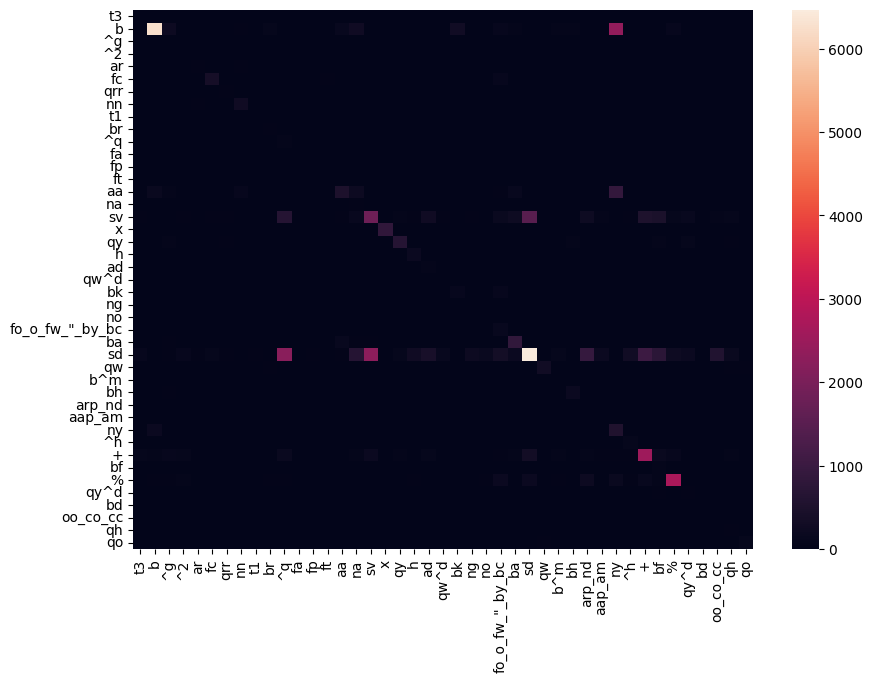

In [ ]:
full_confusion_matrix_plot(classes_balanced)

br accuracy: 99.42%
br precision: 10.70%
br recall: 53.85%


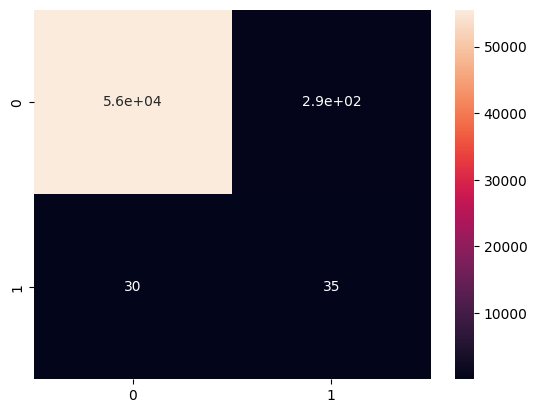

In [ ]:
# Build the confusion matrix off these predictions

br_conf = confusion_matrix_calculator("br", classes_balanced)
br_acc, br_pre, br_rec = metrics_from_conf(br_conf)

print(f"br accuracy: {br_acc*100:.2f}%")
print(f"br precision: {br_pre*100:.2f}%")
print(f"br recall: {br_rec*100:.2f}%")

bf accuracy: 96.80%
bf precision: 3.01%
bf recall: 26.02%


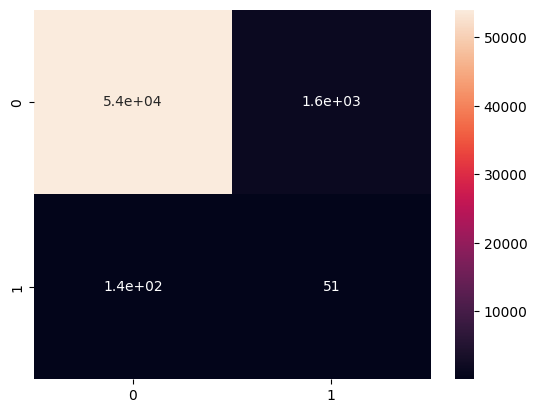

In [ ]:
bf_conf = confusion_matrix_calculator("bf", classes_balanced)
bf_acc, bf_pre, bf_rec = metrics_from_conf(bf_conf)

print(f"bf accuracy: {bf_acc*100:.2f}%")
print(f"bf precision: {bf_pre*100:.2f}%")
print(f"bf recall: {bf_rec*100:.2f}%")

sd accuracy: 74.61%
sd precision: 74.84%
sd recall: 34.96%


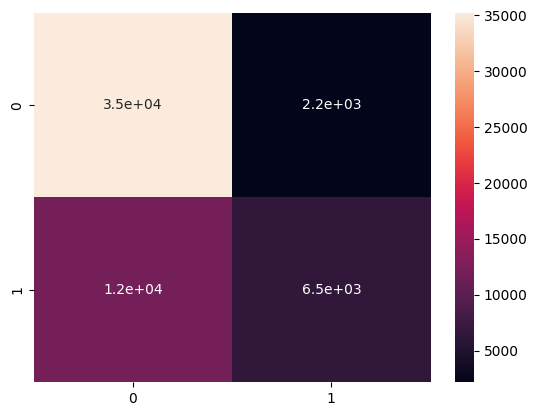

In [ ]:
sd_conf = confusion_matrix_calculator("sd", classes_balanced)
sd_acc, sd_pre, sd_rec = metrics_from_conf(sd_conf)

print(f"sd accuracy: {sd_acc*100:.2f}%")
print(f"sd precision: {sd_pre*100:.2f}%")
print(f"sd recall: {sd_rec*100:.2f}%")

b accuracy: 92.00%
b precision: 91.91%
b recall: 61.56%


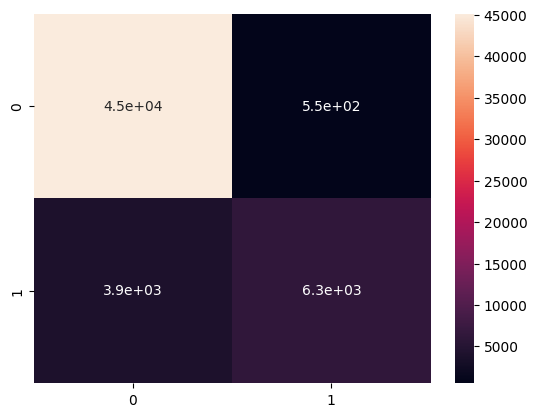

In [ ]:
b_conf = confusion_matrix_calculator("b", classes_balanced)
b_acc, b_pre, b_rec = metrics_from_conf(b_conf)

print(f"b accuracy: {b_acc*100:.2f}%")
print(f"b precision: {b_pre*100:.2f}%")
print(f"b recall: {b_rec*100:.2f}%")





### Explanation



### Other ways to handle imbalanced classes




Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance. 

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [ ]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Input,LSTM
from tensorflow.keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization,MaxPool2D,Concatenate, Flatten


filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

In [ ]:
# concatenate tensors
concat = Concatenate()([maxpool_0, maxpool_1, maxpool_2])

# flatten concatenated tensors

flatten_cnn = TimeDistributed(Flatten())(concat)

# dense layer (dense_1)

dense_1 = Dense(100,activation="relu")(flatten_cnn)

# dropout_1
dropout_1 = Dropout(drop)(dense_1)

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [ ]:
# BLSTM model

# Bidirectional 1
bd1 = Bidirectional(LSTM(100, return_sequences=True))(dropout_1)

# Bidirectional 2
bd2 = Bidirectional(LSTM((100)))(bd1)

##

flt = Flatten()(dropout_1)

# Dense layer (dense_2)

dense_2 = Dense(100, activation="relu")(bd2)

# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer
network

In [ ]:
# concatenate 2 final layers


cnct = Concatenate()([flt, dropout_2])

# output

output = Dense(43, activation="softmax")(cnct)

In [ ]:
model2 = Model(inputs=[inputs], outputs=[output])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 150, 100)     4373200     ['input_4[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 150, 100, 1)  0           ['embedding_3[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 148, 1, 64)   19264       ['reshape[0][0]']                
                                                                                            

In [ ]:
### Write function that does all of the above so I can use TPU

def create_model2():
  inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
  embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
  reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

  # 3 convolutions
  conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  bn_0 = BatchNormalization()(conv_0)
  conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  bn_1 = BatchNormalization()(conv_1)
  conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  bn_2 = BatchNormalization()(conv_2)

  # maxpool for 3 layers
  maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
  maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
  maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

  # concatenate tensors
  concat = Concatenate()([maxpool_0, maxpool_1, maxpool_2])

  # flatten concatenated tensors

  flatten_cnn = TimeDistributed(Flatten())(concat)

  # dense layer (dense_1)

  dense_1 = Dense(100, activation="relu")(flatten_cnn)

  # dropout_1
  dropout_1 = Dropout(drop)(dense_1)

  # BLSTM model

  # Bidirectional 1
  bd1 = Bidirectional(LSTM(100, return_sequences=True))(dropout_1)

  # Bidirectional 2
  bd2 = Bidirectional(LSTM((100)))(bd1)

  ##

  flt = Flatten()(dropout_1)

  # Dense layer (dense_2)

  dense_2 = Dense(100, activation="relu")(bd2)

  # dropout_2
  dropout_2 = Dropout(drop)(dense_2)

  # concatenate 2 final layers

  cnct = Concatenate()([flt, dropout_2])

  # output

  output = Dense(43, activation="softmax")(cnct)

  return Model(inputs=[inputs], outputs=[output])

In [ ]:
with strategy.scope():
  model2 = create_model2()
  model2.compile(loss="categorical_crossentropy",
                         optimizer=Adam(),metrics=['accuracy'])
  
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 150, 100)     4373200     ['input_8[0][0]']                
                                                                                                  
 reshape_4 (Reshape)            (None, 150, 100, 1)  0           ['embedding_7[0][0]']            
                                                                                                  
 conv2d_12 (Conv2D)             (None, 148, 1, 64)   19264       ['reshape_4[0][0]']              
                                                                                            

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [ ]:
# Train the model - use validation
with strategy.scope(): 
  model2.fit(train_input, train_labels, batch_size=100, validation_data=(val_input, val_labels),epochs=5)

Epoch 1/5
1400/1400 [==============================] - 58s 29ms/step - loss: 1.0784 - accuracy: 0.6770 - val_loss: 0.9493 - val_accuracy: 0.7038
Epoch 2/5
1400/1400 [==============================] - 36s 26ms/step - loss: 0.8034 - accuracy: 0.7459 - val_loss: 0.9663 - val_accuracy: 0.7077
Epoch 3/5
1400/1400 [==============================] - 35s 25ms/step - loss: 0.6619 - accuracy: 0.7865 - val_loss: 1.0329 - val_accuracy: 0.7003
Epoch 4/5
1400/1400 [==============================] - 36s 26ms/step - loss: 0.5586 - accuracy: 0.8177 - val_loss: 1.1322 - val_accuracy: 0.6939
Epoch 5/5
1400/1400 [==============================] - 35s 25ms/step - loss: 0.4923 - accuracy: 0.8372 - val_loss: 1.2119 - val_accuracy: 0.6917


In [ ]:
score = model2.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 10s 17ms/step - loss: 1.2072 - accuracy: 0.6965


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 69.64688301086426


In [ ]:
# Generate predictions for the test data
label_pred = model2.predict(test_sentences_X, batch_size=100)

560/560 [==============================] - 7s 12ms/step


In [ ]:
classes_context = np.argmax(label_pred, axis=1)

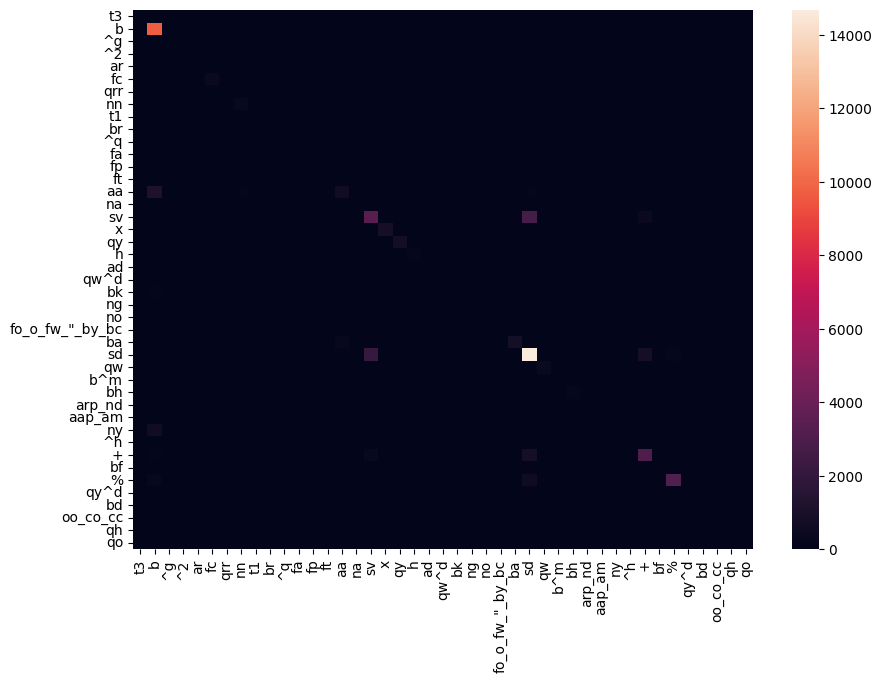

In [ ]:
full_confusion_matrix_plot(classes_context)

br accuracy: 99.91%
br precision: 65.31%
br recall: 49.23%


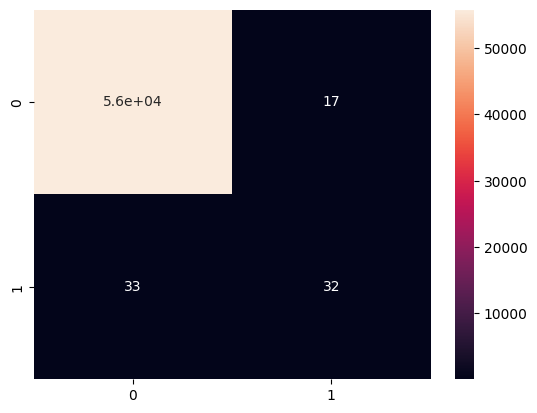

In [ ]:
# Build the confusion matrix off these predictions

br_conf = confusion_matrix_calculator("br", classes_context)
br_acc, br_pre, br_rec = metrics_from_conf(br_conf)

print(f"br accuracy: {br_acc*100:.2f}%")
print(f"br precision: {br_pre*100:.2f}%")
print(f"br recall: {br_rec*100:.2f}%")

bf accuracy: 99.35%
bf precision: 5.35%
bf recall: 5.10%


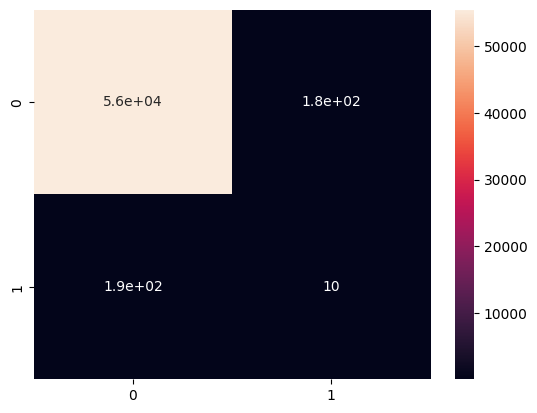

In [ ]:
bf_conf = confusion_matrix_calculator("bf", classes_context)
bf_acc, bf_pre, bf_rec = metrics_from_conf(bf_conf)

print(f"bf accuracy: {bf_acc*100:.2f}%")
print(f"bf precision: {bf_pre*100:.2f}%")
print(f"bf recall: {bf_rec*100:.2f}%")

sd accuracy: 83.84%
sd precision: 73.76%
sd recall: 79.36%


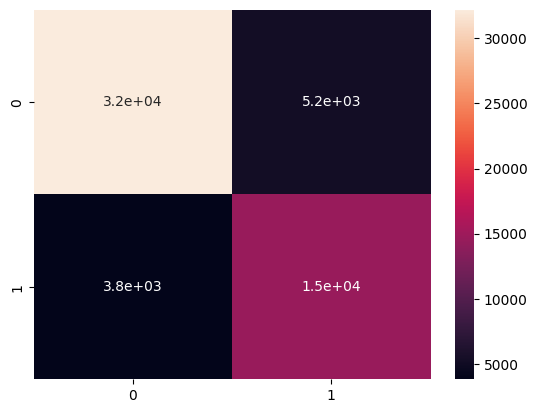

In [ ]:
sd_conf = confusion_matrix_calculator("sd", classes_context)
sd_acc, sd_pre, sd_rec = metrics_from_conf(sd_conf)

print(f"sd accuracy: {sd_acc*100:.2f}%")
print(f"sd precision: {sd_pre*100:.2f}%")
print(f"sd recall: {sd_rec*100:.2f}%")

b accuracy: 94.15%
b precision: 77.56%
b recall: 95.56%


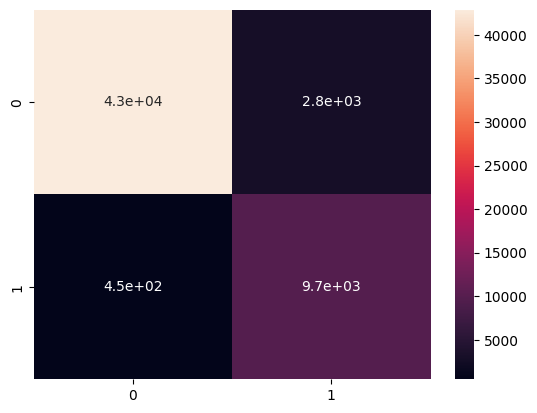

In [ ]:
b_conf = confusion_matrix_calculator("b", classes_context)
b_acc, b_pre, b_rec = metrics_from_conf(b_conf)

print(f"b accuracy: {b_acc*100:.2f}%")
print(f"b precision: {b_pre*100:.2f}%")
print(f"b recall: {b_rec*100:.2f}%")